# 2. Evaluative Feedback

This notebook implements the main ideas, plots and exercises in Chapter 2:
- an n-Armed Bandit environment, which can be either stationary or non-stationary
- an abstract n-Armed Bandit agent class (i.e. the player)
- five implementations of the abstract agent class using the following methods:
    * Action-Value with greedy and $\epsilon$-greedy selection
    * Action-Value with softmax selection
    * Reinforcement Comparison Method (action-preferences)
    * Pursuit Method (action-values and action-preferences)
    * Action-Value with Upper-Confidence-Bound (UCB) selection (from 2nd edition of the book)
- notes on interesting ideas that are new in the 2nd edition of the book

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from abc import abstractclassmethod
%matplotlib inline

First we need a class to generate N-arm bandit tasks (games) as easily as possible. Let's call it <code>NArmBanditGame</code>.
<br><br>
Its constructor defines the number of arms $N$, the randomly initiated arm values, whether they are stationary, etc.
$$arm\_value_i \sim \mathcal{N}(0, 1)$$
The only other method is <code>step(arm)</code>, which basically tells the game which arm $a_t$ has been pulled at each step, thus generating a reward $r_t$. Additionally, if the game is non-stationary the value of each arm drifts following a random walk from their initial value:
$$arm\_value_i = arm\_value_i + drift_i \text{, where  } drift_i \sim \mathcal{N}(0, arm\_value\_drift)$$
The number of <code>steps</code>, <code>current_step</code> and <code>optimal_action</code> are not technically needed to run the environment, but they are useful to keep en eye on how many times the selected action was optimal (see plots below).

In [20]:
"""
    Implements a simple N-armed-bandit game environment.
    It can be stationary or non-stationary with a random walk.
"""
class NArmBanditGame():
    def __init__(self, N, steps, stationary=False, drift=0.1):
        self.rng = np.random.default_rng()
        self.N = N
        self.current_step = 0
        # init the N arms values
        self.arm_value = self.rng.normal(loc=0., scale=1., size=self.N)
        self.optimal_action = np.zeros(steps)
        self.stationary = stationary
        self.arm_value_drift = drift

    def step(self, arm):
        # register whether this was the optimal action
        if arm == np.argmax(self.arm_value):
            self.optimal_action[self.current_step] = 1.
        self.current_step += 1
        # issue a reward for the current action from the chosen arm

        r = self.rng.normal(loc=self.arm_value[arm], scale=1.)
        # or experiment with rewards from a fat-tail distribution too
        # r = self.rng.logistic(loc=self.arm_value[arm], scale=np.sqrt(3.)/np.pi)

        # if non-stationary add random walk for all arms
        if not self.stationary:
            self.arm_value += self.rng.normal(loc=0., scale=self.arm_value_drift, size=self.N)
        return r

    def get_game_stats(self):
        return self.optimal_action

Then we'll need an agent class, <code>NArmBanditAgent</code>, which has two main methods: <code>select_action()</code> and <code>update_internals(a, r)</code>. We call them at each step of the game, the former to first select an action (arm) and the latter to update any internal state we might keep (like action-values, action-preferences or running average rewards) after the arm was played and the corresponding reward was received.
<br><br>
Note that this is an abstract class and we'll write below four slightly different implementations, as described in Chapter 2: Action-value methods (Section 2.2), Reinforcement comparison (Section 2.8) and Pursuit methods (Section 2.9).

In [9]:
"""
    Simple scaffolding for an N-armed bandit agent (Section 2.1)
    At each step it must be able to select one action from N arms
    and to update any internal states it may keep given the reward.
"""
class NArmBanditAgent():
    def __init__(self, N):
        self.rng = np.random.default_rng()
        self.N = N

    @abstractclassmethod
    def select_action(self):
        pass

    @abstractclassmethod
    def update_internals(self, a, r):
        pass

In [10]:
"""
    Implements an Action-Value based agent with (epsilon-)greedy selection (Section 2.2)
    It maintains a vector of action-values, based on sample averages (mainly for stationary problems)
    or using a fixed step-size weight alpha (for non-stationary problems).
    The action selection is greedy or epsilon-greedy if given epsilon > 0.
"""
class NArmBanditAgentActionValueGreedy(NArmBanditAgent):
    def __init__(self, N, alpha=None, epsilon=0):
        super().__init__(N=N)
        self.alpha = alpha  # if None, it uses sample averages
        self.epsilon = epsilon  # zero means pure greedy
        # initialize internal states
        self.Q = np.zeros(N)  # action-values
        self.k = np.zeros(N)  # number of times per arm

    # select the action "a" for the current step
    def select_action(self):
        a = np.argmax(self.Q)  # can be discussed further re breaking ties...
        # if epsilon-greedy, choose an action uniformly with probability epsilon
        if self.epsilon > 0:
            p_explore = self.rng.uniform()
            if p_explore < self.epsilon:
                a = self.rng.choice(self.N)
        return a

    # upon receiving a reward "r" following action "a"
    def update_internals(self, a, r):
        self.k[a] += 1
        if self.alpha is None:
            w = 1. / self.k[a]
        else:
            w = self.alpha
        # update action values
        self.Q[a] = w * r + (1. - w) * self.Q[a]

In [11]:
"""
    Implements an Action-Value based agent with softmax selection (Section 2.3)
    It maintains a vector of action-values, based on sample averages (mainly for stationary problems)
    or using a fixed step-size weight alpha (for non-stationary problems).
    The action is selected from a Gibbs distribution with temperature tau over action-values.
"""
class NArmBanditAgentActionValueSoftmax(NArmBanditAgent):
    def __init__(self, N, alpha=None, tau=1.):
        super().__init__(N=N)
        self.alpha = alpha  # if None, it uses sample averages
        self.tau = tau  # temperature of the Gibbs distribution
        # initialize internal states
        self.Q = np.zeros(N)  # action-values
        self.k = np.zeros(N)  # number of times per arm

    # select the action "a" for the current step
    def select_action(self):
        p_gibbs = np.exp(self.Q / self.tau)
        p_gibbs /= p_gibbs.sum()
        a = self.rng.choice(self.N, p=p_gibbs)
        return a

    # upon receiving a reward "r" following action "a"
    def update_internals(self, a, r):
        self.k[a] += 1
        if self.alpha is None:
            w = 1. / self.k[a]
        else:
            w = self.alpha
        # update action values
        self.Q[a] = w * r + (1. - w) * self.Q[a]

In [12]:
"""
    Implements an agent based on Reinforcement Comparison (Section 2.8)
    We maintain an action-preferences vector p and a reference reward,
    which is an incremental average of all rewards received from all arms.
    Actions are selected according to softmax over preferences, without temperature. (see Exercise 2.9)
"""
class NArmBanditAgentComparisonMethod(NArmBanditAgent):
    def __init__(self, N, alpha, beta, damped_preferences=False):
        super().__init__(N=N)
        self.p = np.zeros(N)  # equal preference initially
        self.r_bar = 0.  # reference reward
        self.alpha = alpha
        self.beta = beta
        # whether to counteract the effect of the
        # r_bar set too low. (see Exercise 2.11)
        # Also see final notes on Gradient Bandit algorithms
        self.damped_preferences = damped_preferences

    def select_action(self):
        p_gibbs = np.exp(self.p)
        p_gibbs /= p_gibbs.sum()
        a = self.rng.choice(self.N, p=p_gibbs)
        return a

    # upon making an action "a" and receiving a reward "r"
    def update_internals(self, a, r):
        # see final notes on Gradient Bandit algorithms
        # as this is actually necessary for gradient ascent
        if self.damped_preferences:
            p_gibbs = np.exp(self.p)
            p_gibbs /= p_gibbs.sum()
            self.p[a] = self.p[a] + self.beta * (r - self.r_bar) * (1. - p_gibbs[a])
            self.r_bar = self.r_bar + self.alpha * (r - self.r_bar)
        else:
            self.p[a] = self.p[a] + self.beta * (r - self.r_bar)
            self.r_bar = self.r_bar + self.alpha * (r - self.r_bar)

In [13]:
"""
    Implements an agent based on the Pursuit methods (Section 2.9)
    We maintain both action-value estimates and action-preferences,
    with the latter continually pursuing the action that is greedy
    according to the action-values.
    Actions are selected directly from the preferences probability or via softmax. (see Exercise 2.13)
"""
class NArmBanditAgentPursuitMethod(NArmBanditAgent):
    def __init__(self, N, beta, alpha=None, use_softmax=False):
        super().__init__(N=N)
        self.Q = np.zeros(N)  # action-values
        self.k = np.zeros(N)  # times arm has been played
        if use_softmax:
            self.p = np.zeros(N)
        else:
            self.p = np.ones(N) / N  # equal preference initially
        self.alpha = alpha
        self.beta = beta
        self.use_softmax = use_softmax

    def select_action(self):
        if self.use_softmax:
            p_gibbs = np.exp(self.p)
            p_gibbs /= p_gibbs.sum()
            a = self.rng.choice(self.N, p=p_gibbs)
        else:
            # select an action based on the preferences (which are also probabilities)
            a = self.rng.choice(self.N, p=self.p)
        return a

    # upon making an action "a" and receiving a reward "r"
    def update_internals(self, a, r):
        self.k[a] += 1
        if self.alpha is None:
            w = 1. / self.k[a]
        else:
            w = self.alpha
        # update action values
        self.Q[a] = w * r + (1. - w) * self.Q[a]

        # the greedy action according to action values
        a_star = np.argmax(self.Q)
        if self.use_softmax:
            # simpy add some constant to the greedy action preference
            self.p[a_star] = self.p[a_star] + self.beta
        else:
            # move the probability of a_star towards 1
            self.p[a_star] = self.p[a_star] + self.beta * (1. - self.p[a_star])
            # and nudge the probabilities of all other actions towards 0
            for a in range(self.N):
                if a != a_star:
                    self.p[a] = self.p[a] + self.beta * (0. - self.p[a])

In [14]:
# Utility function to run a full N-arms testbed over a number of n_games, each with n_steps
# returns the average step by step rewards and optimal action ratios (as in Figure 2.1)
# it is flexible to configure the game type (stationary or non-stationary)
# and to choose the desired agent class and agent parameters (given as dict)
def run_10_armed_testbed(n_games, n_steps, N_arms, stationary, drift, agent_class, agent_params):
    step_by_step_mean_rewards = np.zeros(n_steps)
    optimal_action_rate = np.zeros(n_steps)
    for _ in range(n_games):
        env = NArmBanditGame(N=N_arms, steps=n_steps, stationary=stationary, drift=drift)
        agent = globals()[agent_class](**agent_params)
        for i in range(n_steps):
            a = agent.select_action()
            r = env.step(a)
            agent.update_internals(a=a, r=r)
            step_by_step_mean_rewards[i] += r
        optimal_action_rate += env.get_game_stats()
    # average across n_games
    step_by_step_mean_rewards /= n_games
    optimal_action_rate /= n_games
    return step_by_step_mean_rewards, optimal_action_rate

### Exercise 2.1

In [21]:
n_games = 2000
n_steps = 3000  # triple the number of steps from Figure 2.1
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\epsilon=0$ (greedy)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0,
        )
    ),
    run_2 = dict(
        run_name = r'$\epsilon=0.1$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_3 = dict(
        run_name = r'$\epsilon=0.01$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.01,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\epsilon=0$ (greedy) => 3083.258020644393 (35.05%)
$\epsilon=0.1$ => 4077.2137319164813 (86.45%)
$\epsilon=0.01$ => 4020.784571899303 (77.35%)


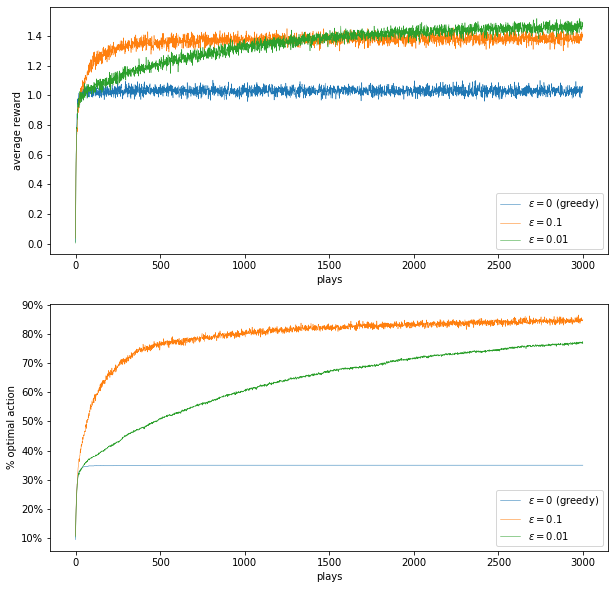

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

### Exercise 2.2

In [11]:
n_games = 2000
n_steps = 1000
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\epsilon=0$ (greedy)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0,
        )
    ),
    run_2 = dict(
        run_name = r'$\epsilon=0.1$ ($\epsilon$-greedy)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_3 = dict(
        run_name = r'$\epsilon=0.01$ ($\epsilon$-greedy)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.01,
        )
    ),
    run_4 = dict(
        run_name = r'$\tau=0.2$ (softmax)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueSoftmax',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            tau = 0.2,
        )
    ),
    run_5 = dict(
        run_name = r'$\tau=0.3$ (softmax)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueSoftmax',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            tau = 0.3,
        )
    ),
    run_6 = dict(
        run_name = r'$\tau=0.4$ (softmax)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueSoftmax',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            tau = 0.4,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\epsilon=0$ (greedy) => 1043.2495506525574 (36.35%)
$\epsilon=0.1$ ($\epsilon$-greedy) => 1300.7682742751485 (80.60%)
$\epsilon=0.01$ ($\epsilon$-greedy) => 1205.3832279484466 (61.15%)
$\tau=0.2$ (softmax) => 1417.619812586951 (75.75%)
$\tau=0.3$ (softmax) => 1374.3230745648216 (72.45%)
$\tau=0.4$ (softmax) => 1302.6917219539155 (64.75%)


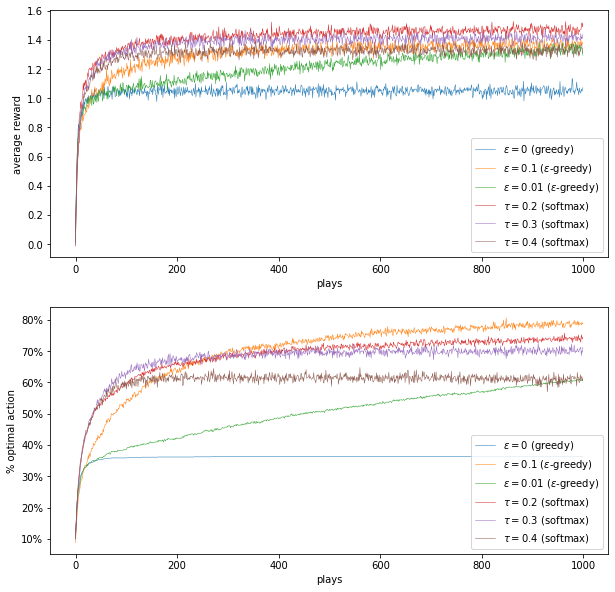

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

One take-away from this exercise was that softmax is much more sensitive to choice of $\tau$ than I expected. It is competitive with $\epsilon$-greedy methods, but somewhat harder to fine tune. One idea that comes to mind is to start with a higher $\tau$ value and then reduce it towards zero (i.e. explore more at the beginning then exploit).

### Exercise 2.7

In [23]:
# similar to above, but initiate non-stationary tasks instead
n_games = 2000
n_steps = 3000  # easier to see longer term results
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\epsilon=0.1, \alpha=1/k$',
        stationary = False,
        drift = 0.1,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_2 = dict(
        run_name = r'$\epsilon=0.1, \alpha=0.1$',
        stationary = False,
        drift = 0.1,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = 0.1,
            epsilon = 0.1,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\epsilon=0.1, \alpha=1/k$ => 107220.76396159799 (48.10%)
$\epsilon=0.1, \alpha=0.1$ => 123646.09198104161 (69.05%)


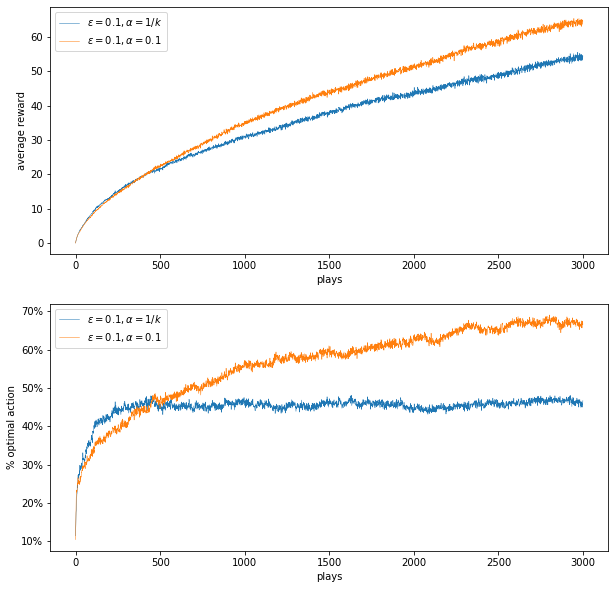

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

Obviously, using a constant $\alpha$ to update action-values leads to recent rewards weighing more and older rewards being "forgotten", as one would wish to solve for a non-stationary problem.

### Exercises 2.9 - 2.11

**Exercise 2.9** <br>The $\tau$ is no longer used because any necessary flexibility could be included directly in the calculation of the action-preferences vector. They are not bound to mean anything (unlike action-values), so numerically they can be manipulated using the $\beta$ parameter.

**Exercise 2.10** <br>If we fix $\alpha = \beta$, then the action-preferences would be updated at the same pace with the reference reward, which may not be necessarily desirable. For instance in non-stationary tasks, one may want to change the action-preferences fast (high $\beta$) to chase the best current action. But since rewards overall remain steady, a low $\alpha$ could be chosen for the reference reward update. We don't want to change the reference too fast anyway, as it would introduce noise after an unusual reward value.


In [15]:
# Exercise 2.11
# similar to above, but with two Comparison agents
n_games = 2000
n_steps = 1000  # easier to see longer term results
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\epsilon$-greedy $\epsilon=0.1, \alpha=1/k$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_2 = dict(
        run_name = r'$\epsilon$-greedy $\epsilon=0.1, \alpha=0.1$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = 0.1,
            epsilon = 0.1,
        )
    ),
    run_3 = dict(
        run_name = r'reinforcement comparison $\alpha=0.1, \beta=0.1$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentComparisonMethod',
        agent_params = dict(
            N = N_arms,
            alpha = 0.1,
            beta = 0.1,
            damped_preferences = False,
        )
    ),
    run_4 = dict(
        run_name = r'reinforcement comp. damped $\alpha=0.1, \beta=0.1$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentComparisonMethod',
        agent_params = dict(
            N = N_arms,
            alpha = 0.1,
            beta = 0.1,
            damped_preferences = True,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\epsilon$-greedy $\epsilon=0.1, \alpha=1/k$ => 1295.8857339144483 (81.40%)
$\epsilon$-greedy $\epsilon=0.1, \alpha=0.1$ => 1254.1245688671015 (79.60%)
reinforcement comparison $\alpha=0.1, \beta=0.1$ => 1358.505173433857 (84.25%)
reinforcement comp. damped $\alpha=0.1, \beta=0.1$ => 1288.0044211510035 (87.65%)


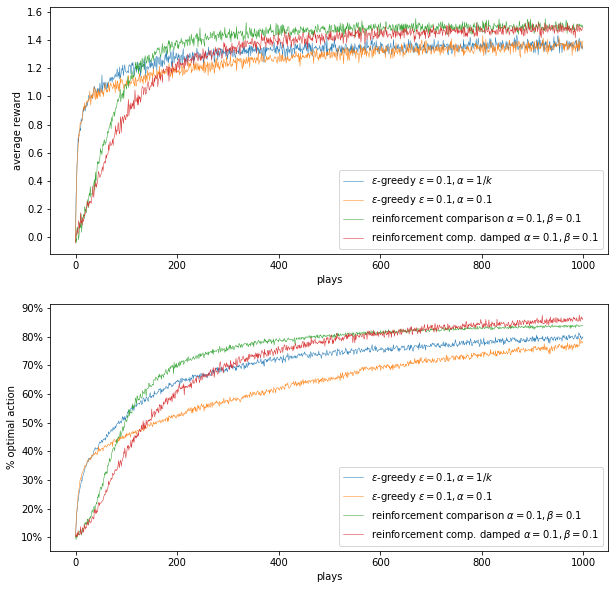

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

### Exercises 2.12 - 2.15
**Exercise 2.12** <br>In the form it is described, the optimal action probability will continually approach 1.

**Exercise 2.13** <br>Similar to Reinforcement comparison methods, apply a softmax (Gibbs distribution over action preferences).

**Exercise 2.15** <br>Maybe instead of action preferences converging to 1 (for the optimal) or 0, clip them to a small constant, i.e. $(1 - \epsilon)$ and $(0 + \epsilon)$ respectively?
$$\pi_{t+1}(a_{t+1}^*) = \pi_t(a_{t+1}^*) + \beta [(1 - \epsilon) - pi_t(a_{t+1}^*)]$$
$$\pi_{t+1}(a) = \pi_t(a) + \beta [(0 + \epsilon) - \pi_t(a)] \text{, for all } a \ne a_{t+1}^*$$

In [17]:
# Exercise 2.14
# same as above, but introduce the Pursuit agent
n_games = 2000
n_steps = 3000  # easier to see longer term results
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\epsilon$-greedy $\epsilon=0.1, \alpha=1/k$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_2 = dict(
        run_name = r'reinforcement comparison $\alpha=0.1, \beta=0.1$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentComparisonMethod',
        agent_params = dict(
            N = N_arms,
            alpha = 0.1,
            beta = 0.1,
            damped_preferences = False,
        )
    ),
    run_3 = dict(
        run_name = r'pursuit $\alpha=1/k, \beta=0.01$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentPursuitMethod',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            beta = 0.01,
            use_softmax = False,
        )
    ),
    run_4 = dict(
        run_name = r'pursuit with softmax $\alpha=1/k, \beta=0.02$',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentPursuitMethod',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            beta = 0.02,
            use_softmax = True,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\epsilon$-greedy $\epsilon=0.1, \alpha=1/k$ => 4021.4309204374235 (85.85%)
reinforcement comparison $\alpha=0.1, \beta=0.1$ => 4348.112589735017 (88.65%)
pursuit $\alpha=1/k, \beta=0.01$ => 4372.376130334178 (90.15%)
pursuit with softmax $\alpha=1/k, \beta=0.01$ => 4329.315625530459 (90.45%)


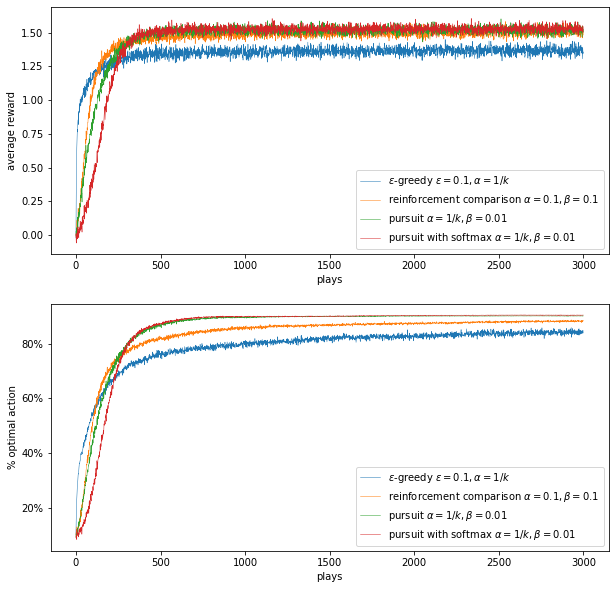

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

### Second Edition of the book
Note that all exercises and section numbers above are from the 1st edition of the book.
<br>

However, in the <a href="http://incompleteideas.net/book/the-book-2nd.html">2nd edition</a> there are some interesting new ideas which I will try to implement below, like the Unbiased Constant-Step-Size Trick (Exercise 2.7) or the Upper-Confidence-Bound Action Selection (_UCB_) in Section 2.7.
<br>
<br>

**Note:** The notation and symbols have changed slightly in the 2nd edition, but I've used the ones from the 1st edition here.

### Exercise 2.7 (2nd edition) - Unbiased constant-step-size trick
When we're using a constant step size $\alpha$ as we did above for non-stationary problems, the value estimate is:
$$ Q_{k+1} = Q_k + \alpha (r_{k+1} - Q_k) $$
which when unrolled gives:
$$Q_{k+1} = (1 - \alpha)^k Q_0 + \sum_{i=1}^k \alpha (1 - \alpha)^{k-i}r_i $$
which is a weighted average of all past rewards $r_i$ _and_ the initial chosen value $Q_0$, therefore producing a biased estimate of the true $Q^*$. This exercise introduces a trick to benefit from both an unbiased estimate (like sample averages) and an exponential recency-weighted average that's useful in non-stationary problems.
<br>

The idea is to replace $\alpha$ in the equation above by a value $\beta_{k}$ at each step $k$, defined as:
$$ \beta_{k} := \alpha / \bar{o}_k $$
where $\alpha \in (0, 1)$ is a constant and $\bar{o}_k$ is a trace that starts at $0$:
$$ \bar{o}_k := \bar{o}_{k-1} + \alpha (1 - \bar{o}_{k-1}), \: \text{ for } \: n>0, \: \text{ with } \: \bar{o}_0 := 0 $$
<br>

To prove that this is a suitable method, we need to prove three things:
1. that the choice of $Q_0$ is no longer a part of the estimate $Q_k$ at any step $k > 0$
2. that the weights of rewards $\{r_i\}$ decrease exponentially as they "become old" inside of the weighted average $Q_k$
3. that the sum of the weights equals $1$
<br>
<br>

**Proofs**
***
1. At any step $k > 0$, the estimate is given by: 
$$ Q_k := Q_{k-1} + \beta_k (r_k - Q_{k-1}) \qquad (1) $$
So we have: 
$$ Q_1 = Q_0 + \beta_1 (r_1 - Q_0) \qquad (2) $$
But from the definitions above: 
$$ \beta_1 = \frac{\alpha}{\bar{o}_1} = \frac{\alpha}{\bar{o}_0 + \alpha (1 - \bar{o}_0)} = \frac{\alpha}{\alpha} = 1 \qquad (3)$$
From $(2) \text{ and } (3)$ it follows that $Q_1 = r_1$, so it doesn't depend on $Q_0$. Also, from the recursive equation $(1)$ it follows that the next ones $Q_2, Q_3, ...$ all depend on the set of rewards $\{r_i, i > 0\}$ and on the set of coefficients $\{\beta_i, i > 0\}$ only.
<br>
<br>

2. We first rewrite and unroll the recursive equation $(1)$ into:
$$ Q_k = Q_{k-1} (1 - \beta_k) + \beta_k r_k $$
$$ = Q_{k-2} (1 - \beta_{k-1})(1 - \beta_k) + \beta_{k-1} (1 - \beta_k) r_{k-1} + \beta_k r_k $$
$$ ... $$
$$ = Q_0 \prod_{i=1}^{k}(1 - \beta_i) + \sum_{i=1}^{k} \left( r_i \beta_i \prod_{j=i+1}^{k}{(1 - \beta_j)} \right) \qquad (4) $$

We have already proven above that $Q_0$ is not part of any estimate $Q_k, \text{ for } k>0$, but we can also prove it by pointing out that $ \prod_{i=1}^{k}(1 - \beta_i) $ is actually zero for all $k>0$, since the first factor $(1 - \beta_1) = 0$, as per $(3)$.
So we discard the first term of (4) and remain with
$$ Q_k = \sum_{i=1}^{k} \left( r_i \beta_i \prod_{j=i+1}^{k}{(1 - \beta_j)} \right) \qquad (5) $$

Now let's rewrite any factor $(1 - \beta_k)$:
$$ 1 - \beta_k = 1 - \frac {\alpha} {\bar{o}_k} = \frac {\bar{o}_k - \alpha} {\bar{o}_k} = \frac {\bar{o}_{k-1} + \alpha(1 - \bar{o}_{k-1}) - \alpha} {\bar{o}_k} = (1 - \alpha) \frac {\bar{o}_{k-1}} {\bar{o}_{k}} \qquad (6) $$

From $(5) \text{ and } (6)$ it follows that:
$$ Q_k = \sum_{i=1}^{k} \left( r_i \beta_i (1 - \alpha)^{k-i} \prod_{j=i+1}^{k}{\frac {\bar{o}_{j-1}} {\bar{o}_{j}}} \right) $$
$$ = \sum_{i=1}^{k} \left( r_i \beta_i (1 - \alpha)^{k-i} \frac {\bar{o}_{i}} {\bar{o}_{k}} \right) $$
$$ = \sum_{i=1}^{k} \left( r_i (1 - \alpha)^{k-i} \frac {\alpha} {\bar{o}_{i}} \cdot \frac {\bar{o}_{i}} {\bar{o}_{k}} \right) $$
$$ = \beta_{k} \sum_{i=1}^{k} (1 - \alpha)^{k-i} r_i \qquad (7)$$
So
$$ Q_k = \beta_{k} \left[r_k + (1 - \alpha)^1 r_{k-1} + (1 - \alpha)^2 r_{k-2} + ... + (1 - \alpha)^{k-1} r_1 \right] $$

which proves our second point, as the factor of each reward $r_i$ is weighted proportionally to $(1 - \alpha)^{k-i}$ (ignoring for now the factor $\beta_{k}$). Also note that since $0 < \alpha < 1$, the factors $(1 - \alpha)^{k-i}$ become exponentially smaller for rewards from further in the past.
<br>
<br>

3. The last thing remaining is to prove that the sum of all the weights is equal to $1$, that is for all $k > 0$:
$$ \beta_{k} \sum_{i=1}^{k} (1 - \alpha)^{k-i} = 1 $$
$$ \iff \beta_{k} \sum_{i=0}^{k-1} (1 - \alpha)^{i} = 1 $$
$$ \iff \beta_{k} \frac {(1 - \alpha)^{k} - 1} {(1 - \alpha) - 1} = 1 $$
$$ \iff \frac {\alpha} {\bar{o}_k} \cdot \frac {1 - (1 - \alpha)^{k}} {\alpha} = 1 $$
$$ \iff \bar{o}_k = 1 - (1 - \alpha)^{k} \qquad (8) $$

We'll prove the last equation by induction from the definition of $\bar{o}_k$:

First, as shown in (3), $\bar{o}_1 = \alpha = 1 - (1 - \alpha)^1$.

Then assuming the relation $(8)$ is true for some $\bar{o}_k$, we prove it for $\bar{o}_{k+1}$. From definition:
$$ \bar{o}_{k+1} = \bar{o}_k + \alpha (1 - \bar{o}_k) $$
$$ = (1 - \alpha) \bar{o}_k + \alpha $$
$$ = (1 - \alpha) [1 - (1 - \alpha)^{k}] + \alpha $$
$$ = (1 - \alpha) - (1 - \alpha)^{k+1} + \alpha $$
$$ = 1 - (1 - \alpha)^{k+1} $$
which concludes our proof.

### Section 2.7 (2nd edition) - UCB (Upper Confidence Bound) Action Selection
This algorithm is not present in the 1st edition, so we'll implement it here for comparison with the ones above.
The main idea is to strike a better balance between exploitation and exploration by adding another term to the $Q_k^a$ value for each action $a$, which takes into consideration the time step we reached $t$ and the number of times $k^a$ than the action $a$ was selected in the past:
$$ a_t := \underset{a}{\arg\max} \left[ Q_{k^a} + c \sqrt {\frac {ln\:t}{k^a}} \right] $$
Note that $a$ is not a power, but a superscript to indicate we're looking at the $Q_k$ and $k$ corresponding to each action $a$. Also $t$ determines the current step in the game, while $k$ is the number of times each action was selected. In other words, $t = \sum_{a} k^a$.
<br>
So UCB is similar to $\epsilon$-greedy for choosing the $\underset{a}{\arg\max}$, but the exploration is controlled by the small constant $c$ and the second term. Implementation below, comparing it with $\epsilon$-greedy and softmax.

In [5]:
"""
    Implements an Action-Value based agent with UCB selection (Section 2.7 in 2nd edition).
    It maintains a vector of action-values, based on sample averages (mainly for stationary problems)
    or using a fixed step-size weight alpha (for non-stationary problems).
    The action selection is greedy over UCB-adjusted values of Q[a].
"""
class NArmBanditAgentUCB(NArmBanditAgent):
    def __init__(self, N, alpha=None, c=0.):
        super().__init__(N=N)
        self.alpha = alpha  # if None, it uses sample averages
        self.c = c  # zero means pure greedy, unadjusted
        # initialize internal states
        self.Q = np.zeros(N)  # action-values
        self.k = np.zeros(N)  # number of times per arm

    # select the action "a" for the current step
    def select_action(self):
        # calculate current step "t"
        t = self.k.sum() + 1  # can also be stored as state internally, but didn't bother
        a = np.argmax(self.Q + self.c * np.sqrt(np.log(t) / (self.k + 1e-3))) # avoid div by 0 and force explore unseen actions
        return a

    # upon receiving a reward "r" following action "a"
    def update_internals(self, a, r):
        self.k[a] += 1
        if self.alpha is None:
            w = 1. / self.k[a]
        else:
            w = self.alpha
        # update action values
        self.Q[a] = w * r + (1. - w) * self.Q[a]

In [34]:
n_games = 2000
n_steps = 3000
N_arms = 10

results = dict(
    run_1 = dict(
        run_name = r'$\tau=0.2$ (softmax)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueSoftmax',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            tau = 0.2,
        )
    ),
    run_2 = dict(
        run_name = r'$\epsilon=0.1$ ($\epsilon$-greedy)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentActionValueGreedy',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            epsilon = 0.1,
        )
    ),
    run_3 = dict(
        run_name = r'UCB (c=2)',
        stationary = True,
        drift = None,
        agent_class = 'NArmBanditAgentUCB',
        agent_params = dict(
            N = N_arms,
            alpha = None,
            c = 2.,
        )
    ),
)

for run in results:
    step_by_step_mean_rewards, optimal_action_rate = run_10_armed_testbed(
        n_games=n_games,
        n_steps=n_steps,
        N_arms=N_arms,
        stationary=results[run]['stationary'],
        drift=results[run]['drift'],
        agent_class=results[run]['agent_class'],
        agent_params=results[run]['agent_params'],
    )
    results[run]['step_by_step_rewards'] = step_by_step_mean_rewards
    results[run]['optimal_action_rate'] = optimal_action_rate * 100.

    print(f"{results[run]['run_name']} => {results[run]['step_by_step_rewards'].sum()} ({results[run]['optimal_action_rate'].max():.2f}%)")

$\tau=0.2$ (softmax) => 4295.1597333313985 (79.35%)
$\epsilon=0.1$ ($\epsilon$-greedy) => 4031.4655640956325 (85.20%)
UCB (c=2) => 4476.641942290737 (93.55%)


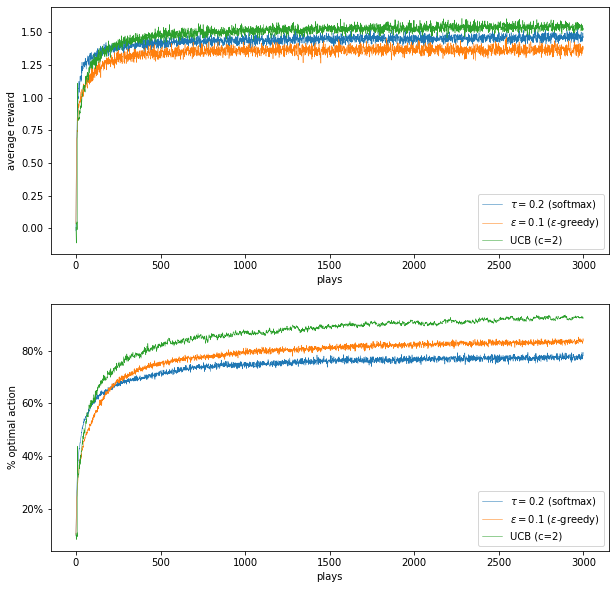

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for run in results:
    ax[0].plot(results[run]['step_by_step_rewards'], linewidth=0.5, label=results[run]['run_name'])
    ax[1].plot(results[run]['optimal_action_rate'], linewidth=0.5, label=results[run]['run_name'])

ax[0].set_ylabel('average reward')
ax[0].set_xlabel('plays')
ax[0].legend()

ax[1].set_ylabel('% optimal action')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_xlabel('plays')
ax[1].legend()
plt.show()

### Section 2.8 (2nd edition) Bandit Gradient Algorithms
The two algorithms called Reinforcement Comparison and Pursuit Methods in the 1st edition seem to have been replaced by Bandit Gradient Algorithms. They all use some form of action-preferences instead of action-values, and the rename is due to the insight that the update equation of action-preferences is equivalent (in expected value) to gradient ascent by moving in the direction of $ \frac {\partial \mathbb{E} [R_t]} {\partial p_t(a)} $. Therefore it is a form of stochastic gradient ascent.
Mathematical proof is interesting to see in the 2nd edition.